In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Carga data

In [2]:
infile = open('cleandata_pickle.pickle','rb')
data_clean = pickle.load(infile)
infile.close()

### Agregar variables temporales

In [3]:
data_clean['dow_creacion'] = data_clean['dttm_creacion'].dt.dayofweek
data_clean['hora_creacion'] = data_clean['dttm_creacion'].dt.hour
data_clean['mes_creacion'] = data_clean['dttm_creacion'].dt.month
data_clean['año_creacion'] = data_clean['dttm_creacion'].dt.year
data_clean['fecha_creacion'] = data_clean['dttm_creacion'].dt.floor('D')
data_clean['dow_cierre'] = data_clean['dttm_cierre'].dt.dayofweek
data_clean['hora_cierre'] = data_clean['dttm_cierre'].dt.hour
data_clean['mes_cierre'] = data_clean['dttm_cierre'].dt.month
data_clean['año_cierre'] = data_clean['dttm_cierre'].dt.year
data_clean['fecha_cierre'] = data_clean['dttm_cierre'].dt.floor('D')

### Agregar geopoint de nuevo

In [4]:
data_clean['geopoint'] = data_clean['longitud'].round(5).astype('string')+','+data_clean['latitud'].round(5).astype('string')

### Cambiar a minúsculas las variables  `string`

In [5]:
data_clean['clas_con_f_alarma'] = data_clean['clas_con_f_alarma'].str.lower().replace(" ", "_", regex = True, inplace=False)
data_clean['tipo_entrada'] = data_clean['tipo_entrada'].str.lower().replace(" ", "_", regex = True, inplace=False).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
data_clean.head()

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,hora_creacion,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre,geopoint
1164271,C4/131231/03508,A,alvaro obregon,lesionado_atropellado,19.33929,-99.25598,urgencias_medicas,llamada_del_066,alvaro obregon,2013-12-31 23:21:38,...,23,12,2013,2013-12-31,2,1,1,2014,2014-01-01,"-99.25598,19.33929"
1164423,C4/131231/02371,N,alvaro obregon,accidente_choque_sin_lesionados,19.37831,-99.20090,emergencia,llamada_del_066,alvaro obregon,2013-12-31 18:21:47,...,18,12,2013,2013-12-31,3,0,1,2014,2014-01-02,"-99.2009,19.37831"
372612,C4/140101/04189,A,alvaro obregon,accidente_choque_con_lesionados,19.36336,-99.19104,urgencias_medicas,llamada_del_066,alvaro obregon,2014-01-01 21:45:43,...,21,1,2014,2014-01-01,2,23,1,2014,2014-01-01,"-99.19104,19.36336"
372622,C4/140101/04201,A,alvaro obregon,accidente_choque_sin_lesionados,19.36348,-99.19145,emergencia,llamada_del_066,alvaro obregon,2014-01-01 21:46:46,...,21,1,2014,2014-01-01,2,21,1,2014,2014-01-01,"-99.19145,19.36348"
372628,C4/140101/01293,A,alvaro obregon,accidente_choque_sin_lesionados,19.38161,-99.20009,emergencia,llamada_del_066,alvaro obregon,2014-01-01 06:50:48,...,6,1,2014,2014-01-01,2,8,1,2014,2014-01-01,"-99.20009,19.38161"


### Agrega columna label. Identifica las llamadas falsas de las verdaderas

Es importante hacer una distinción entre "registros recibidos" e "incidentes reales".

In [6]:
data_clean['label'] = np.where((data_clean['codigo_cierre'] == 'N') | (data_clean['codigo_cierre'] == 'F') ,1,0 )

Corroboramos que la columna label es correcta

In [7]:
data_clean[['label','codigo_cierre']].value_counts()

label  codigo_cierre
0      A                599965
       D                495388
1      N                271600
       F                 10485
0      I                  5096
dtype: int64

## GEDA

### ¿Coincide latitud y longitud con la delegación correspondiente?

In [142]:
#f = plt.subplots(figsize = (6,7))

#sns.scatterplot(data = data_clean.drop_duplicates(subset = ['latitud', 'longitud', 'delegacion_inicio']), 
#                y = "latitud", x = "longitud", hue = "delegacion_inicio")

#ax = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Parece ser que existen varios puntos *fuera de lugar*. Separemos cada delegación para apreciar mejor estos puntos.
De igual manera, veamos qué puntos son los que más se repiten

In [141]:
#lat_long_deleg_counts = data_clean.groupby(['latitud', 'longitud', 'delegacion_inicio']).size().reset_index(name = 'n')
#pal = sns.color_palette("mako", as_cmap=True)
#ax = sns.relplot(data = lat_long_deleg_counts, x = 'longitud', y = 'latitud', col = 'delegacion_inicio', hue = 'n', col_wrap = 4, palette= pal)

In [140]:
#pal = sns.color_palette("flare", as_cmap=True)
#ax = sns.relplot(data = lat_long_deleg_counts.query('n > 400'), x = 'longitud', y = 'latitud', col = 'delegacion_inicio', hue = 'n', 
#                 col_wrap = 4, palette= pal, alpha = 0.8)

In [139]:
#data_clean.drop_duplicates(subset = ['latitud', 'longitud', 'delegacion_inicio'])

In [138]:
#top_geopoints = data_clean[['geopoint']].value_counts().head(16).reset_index(name = 'n').geopoint.values
#top_geopoints

In [137]:
#data_clean[['label','geopoint']].value_counts().reset_index(name = 'n').pivot('geopoint','label', 'n').reset_index().sort_values(by = [1], ascending = False)


In [136]:
#data_clean[data_clean['geopoint'].isin(top_geopoints)]

In [135]:
#ax = sns.catplot(data = data_clean[data_clean['geopoint'].isin(top_geopoints)],
#                 x = 'label', kind = 'count', col = 'geopoint', col_wrap= 4, sharey = False)

### Llamadas por día de la semana y hora de creación

In [26]:
dic_dow = {0 : "Lun", 1 : "Mar", 2 : "Mie", 3 : "Jue", 4: "Vie", 5 : "Sab", 6: "Dom"}

dow_x_hora_creacion = data_clean.replace({'dow_creacion' : dic_dow})[['dow_creacion', 'hora_creacion']].groupby(['dow_creacion', 'hora_creacion']).\
size().reset_index(name='n').pivot("hora_creacion", "dow_creacion","n")

dow_x_hora_creacion = dow_x_hora_creacion[['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab','Dom']]

# * 3

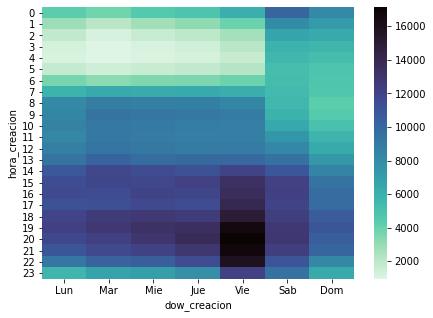

In [27]:
f = plt.subplots(figsize = (7,5))
pal = sns.color_palette("mako_r", as_cmap=True)
ax = sns.heatmap(dow_x_hora_creacion, cmap = pal)

### Llamadas por día de la semana y mes de creación

Cuando más llamadas hay es los viernes entre 18 y 22 hrs. Cuando menos llamadas hay es de lunes a viernes de 12am a 6am

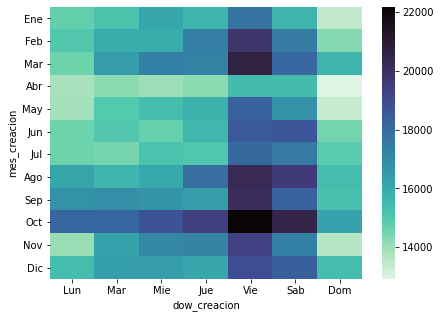

In [58]:
dic_mes = {1:'Ene', 2:'Feb', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dic'}

dow_x_mes_creacion = data_clean.replace({'dow_creacion' : dic_dow, 'mes_creacion' : dic_mes})[['dow_creacion', 'mes_creacion']].groupby(['dow_creacion', 'mes_creacion']).\
size().reset_index(name='n').pivot("mes_creacion", "dow_creacion","n")

#Reordena columnas
dow_x_mes_creacion = dow_x_mes_creacion[dic_dow.values()]
#Reordena renglones
dow_x_mes_creacion = dow_x_mes_creacion.reindex(dic_mes.values())

f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(dow_x_mes_creacion, cmap = pal)
plt.yticks(rotation=0) 

plt.show()

### Llamadas por año y mes de creación

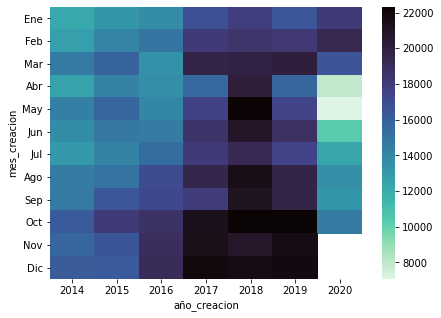

In [59]:
año_x_mes_creacion = data_clean.replace({'mes_creacion' : dic_mes})[['año_creacion', 'mes_creacion']].groupby(['año_creacion', 'mes_creacion']).\
size().reset_index(name='n').query('año_creacion != 2013').pivot("mes_creacion", "año_creacion","n")

año_x_mes_creacion = año_x_mes_creacion.reindex(dic_mes.values())

f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(año_x_mes_creacion, cmap = pal)

plt.yticks(rotation=0) 

plt.show()

### Llamadas por delegación

# *

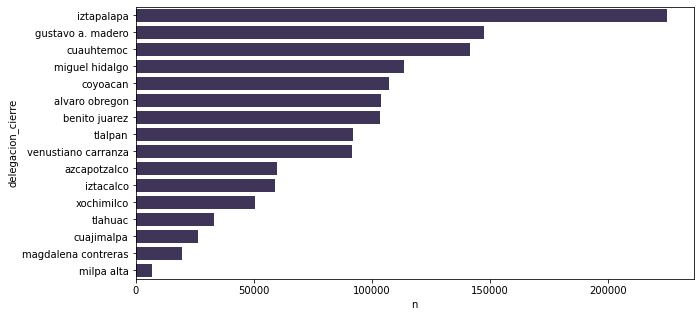

In [87]:
llamadas_x_deleg = data_clean.groupby(['delegacion_cierre']).size().reset_index(name = "n").sort_values("n", ascending = False)

pal = sns.color_palette("mako",30)

f = plt.subplots(figsize = (10,5))
ax = sns.barplot(data = llamadas_x_deleg, x = 'n', y = 'delegacion_cierre', color = pal[6])

### Llamadas por año

In [90]:
#llamadas_x_año = data_clean.query('año_creacion != 2013').groupby(['año_creacion']).size().reset_index(name = "n").sort_values("n", ascending = False)
#llamadas_x_año['año_creacion'] = llamadas_x_año['año_creacion'].astype("object")

#f = plt.subplots(figsize = (5,7))
#ax = sns.barplot(data = llamadas_x_año, y = 'n', x = 'año_creacion', color= 'b')

### Serie de tiempo llamadas

In [89]:
#llamadas_diarias = data_clean.groupby(['fecha_creacion']).size().reset_index(name = "n")
#f = plt.subplots(figsize = (15,5))
#ax = sns.lineplot(data = llamadas_diarias, x = 'fecha_creacion', y = 'n')

### Serie de tiempo de llamadas por codigo_cierre

In [88]:
#llamadas_diarias_codigo = data_clean.groupby(['fecha_creacion', 'codigo_cierre']).size().reset_index(name = "n")
#llamadas_diarias_codigo

#f = plt.subplots(figsize = (15,5))
#ax = sns.relplot(data = llamadas_diarias_codigo, x = 'fecha_creacion', y = 'n', hue = 'codigo_cierre', col = 'codigo_cierre', kind = 'line', col_wrap = 3)

### Llamadas según codigo_cierre

In [91]:
#llamadas_x_codigo_cierre = data_clean.groupby(['codigo_cierre']).size().reset_index(name = "n").sort_values("n", ascending = False)
#f = plt.subplots(figsize = (8,6))
#ax = sns.barplot(data = llamadas_x_codigo_cierre, x = 'n', y = 'codigo_cierre', color= 'g')

# * Obligatoria

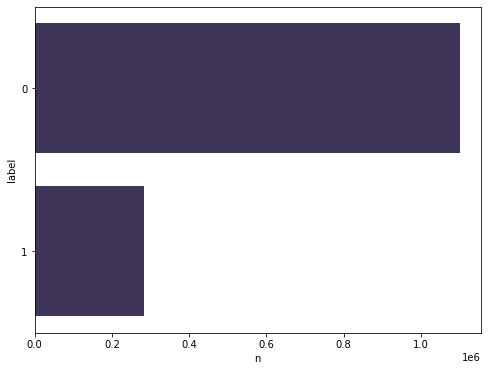

In [95]:
llamadas_x_label = data_clean.groupby(['label']).size().reset_index(name = "n").sort_values("n", ascending = False)
llamadas_x_label['label'] = llamadas_x_label.astype('str') 
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_label, x = 'n', y = 'label', color= pal[6])

### Serie de tiempo de llamadas según label

In [96]:
#llamadas_diarias_label = data_clean.groupby(['fecha_creacion', 'label']).size().reset_index(name = "n")

#f = plt.subplots(figsize = (15,5))
#ax = sns.relplot(data = llamadas_diarias_label, x = 'fecha_creacion', y = 'n', col = 'label', kind = 'line', col_wrap = 1)

# * 

### Incidente C4 

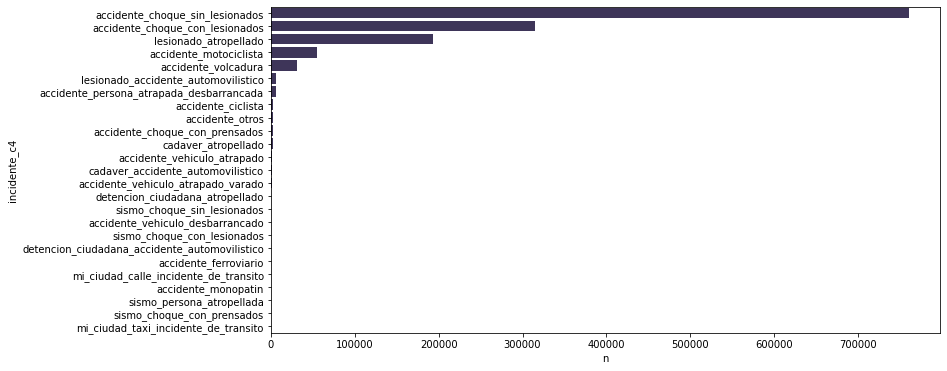

In [97]:
llamadas_x_incidente = data_clean.groupby(['incidente_c4']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (12,6))
ax = sns.barplot(data = llamadas_x_incidente, x = 'n', y = 'incidente_c4', color= pal[6])

# * 

### Incidentes según tipo_entrada

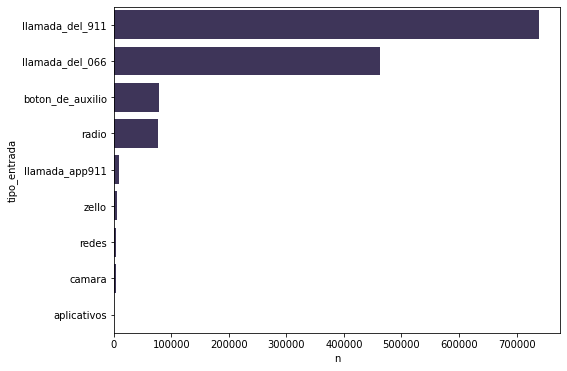

In [98]:
llamadas_x_tipo_entrada = data_clean.groupby(['tipo_entrada']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_tipo_entrada, x = 'n', y = 'tipo_entrada', color= pal[6])

### Clasificación de la llamada

In [99]:
#llamadas_x_clas = data_clean.groupby(['clas_con_f_alarma']).size().reset_index(name = "n").sort_values("n", ascending = False)
#f = plt.subplots(figsize = (8,6))
#ax = sns.barplot(data = llamadas_x_clas, x = 'n', y = 'clas_con_f_alarma', color= 'b')

### Incidentes por codigo_cierre y clasificacion

In [100]:
#ax = sns.catplot(data = data_clean, x = 'codigo_cierre', col = 'clas_con_f_alarma', kind = 'count' , sharey = True, col_wrap = 2,
#                 col_order = ['emergencia', 'urgencias_medicas', 'delito', 'falsa_alarma'])
#(ax.set_axis_labels("Codigo Cierre", ""))

In [101]:
#ax = sns.catplot(data = data_clean, x = 'codigo_cierre', col = 'clas_con_f_alarma', kind = 'count' , sharey = False,col_wrap = 2,
#                 col_order = ['emergencia', 'urgencias_medicas', 'delito', 'falsa_alarma'])
#(ax.set_axis_labels("Codigo Cierre", ""))

Se observa que, en su mayoría, la etiqueta FALSA ALARMA de la columna `clas_con_f_alarma` sí coincide con el valor F de `codigo_cierre`

Es importante notar que no se cuenta con la variable `clas_con_f_alarma` al momento de recibir una llamada, por lo que esta variable no es útil para predecir `label`

## Predicción de Label

Observemos las proporciones de label a lo largo de cada nivel de algunas variables

# * Hacer con step_others 

In [122]:
data_copy = data_clean.copy()

incidentes_top = data_clean.incidente_c4.value_counts().head(7).reset_index(name = "n")['index'].values
data_copy['incidente'] = np.where((data_clean['incidente_c4'].isin(incidentes_top)) ,data_clean['incidente_c4'],"otros" )

In [132]:
orden_incidentes = ["accidente_choque_sin_lesionados","accidente_choque_con_lesionados","lesionado_atropellado", "accidente_motociclista",\
                    "accidente_volcadura","lesionado_accidente_automovilistico", "accidente_persona_atrapada_desbarrancada", "otros"]

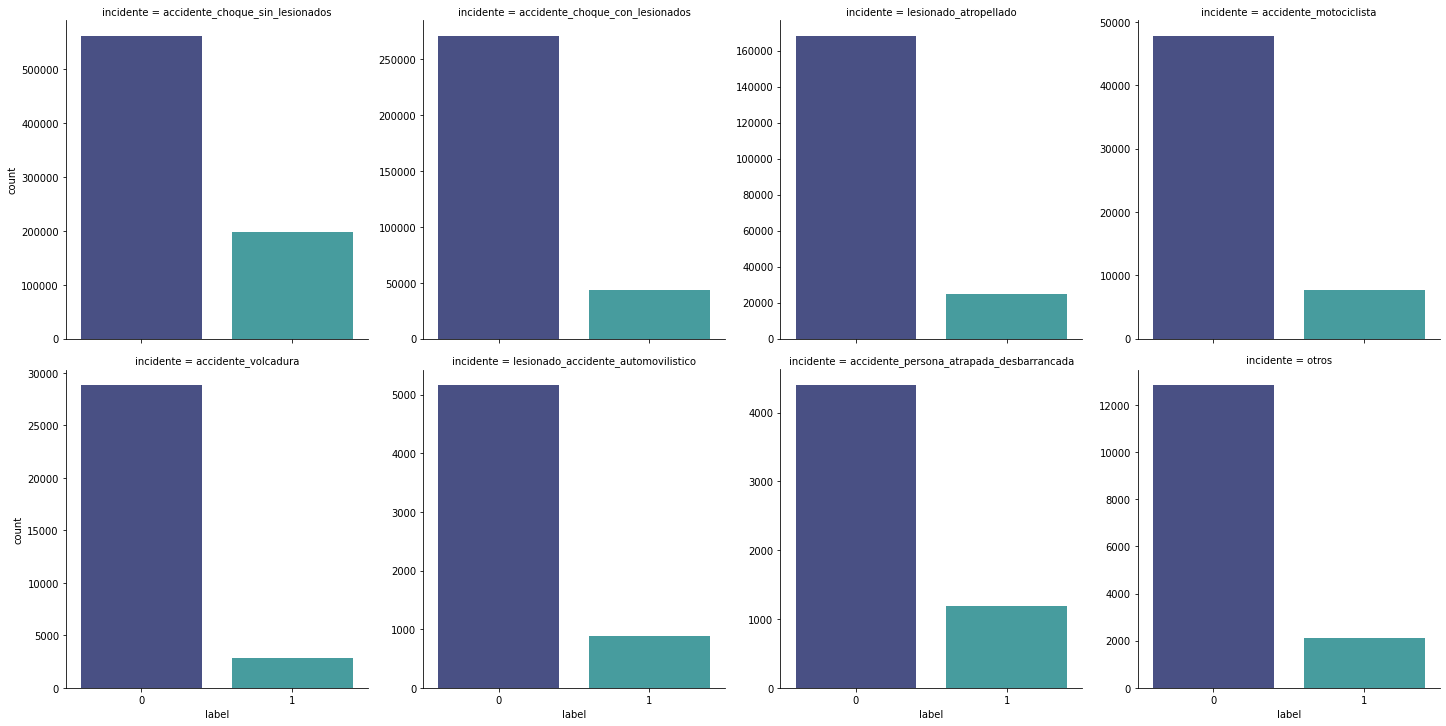

In [123]:
pal = sns.color_palette('mako',2)
ax = sns.catplot(data = data_copy, x = 'label', kind = 'count', col = 'incidente', col_wrap= 4, sharey = False, palette = pal, col_order = orden_incidentes)

### Delegación

In [126]:
orden_delegaciones=['iztapalapa', 'gustavo a. madero', 'cuauhtemoc', 'miguel hidalgo', 'coyoacan', 'alvaro obregon', 'benito juarez',\
                    'tlalpan', 'venustiano carranza', 'azcapotzalco','iztacalco', 'xochimilco', 'tlahuac', 'cuajimalpa', 'magdalena contreras', 'milpa alta']

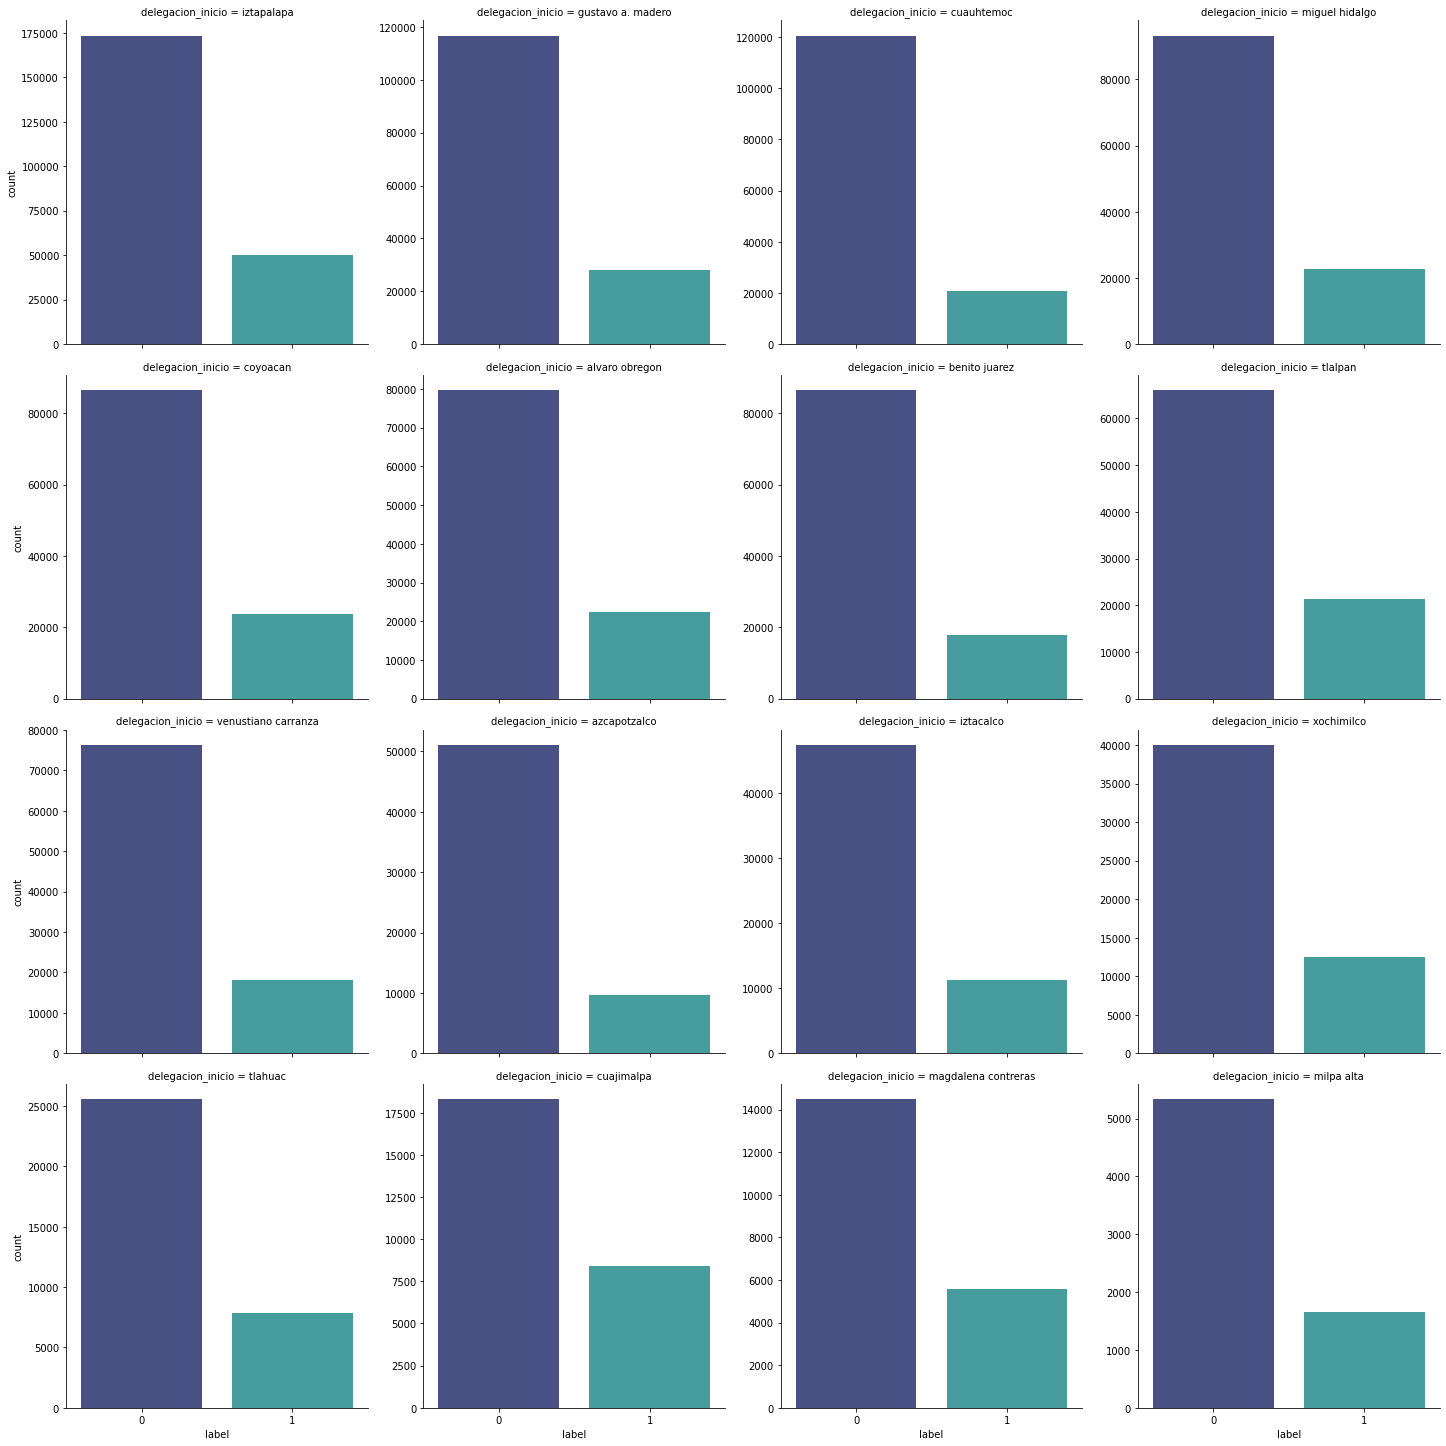

In [127]:
ax = sns.catplot(data = data_clean, x = 'label', kind = 'count', col = 'delegacion_inicio', col_wrap= 4, sharey = False, palette = pal,
                col_order = orden_delegaciones )

Vemos que en Cuajimalpa hay un alta proporción de llamadas falsas, mientras que en cuauhtemoc, benito juarez y azcapotzalco hay una proporción mas baja.

# *

### Tipo de entrada

In [128]:
tipo_entradas_top = data_clean.tipo_entrada.value_counts().head(7).reset_index(name = "n")['index'].values
data_copy['tipo_entrada'] = np.where((data_clean['tipo_entrada'].isin(tipo_entradas_top)) ,data_clean['tipo_entrada'],"otros" )

In [129]:
orden_entradas = ['llamada_del_911', 'llamada_del_066', 'radio', 'boton_de_auxilio', 'otros']
orden_entradas

['llamada_del_911', 'llamada_del_066', 'radio', 'boton_de_auxilio', 'otros']

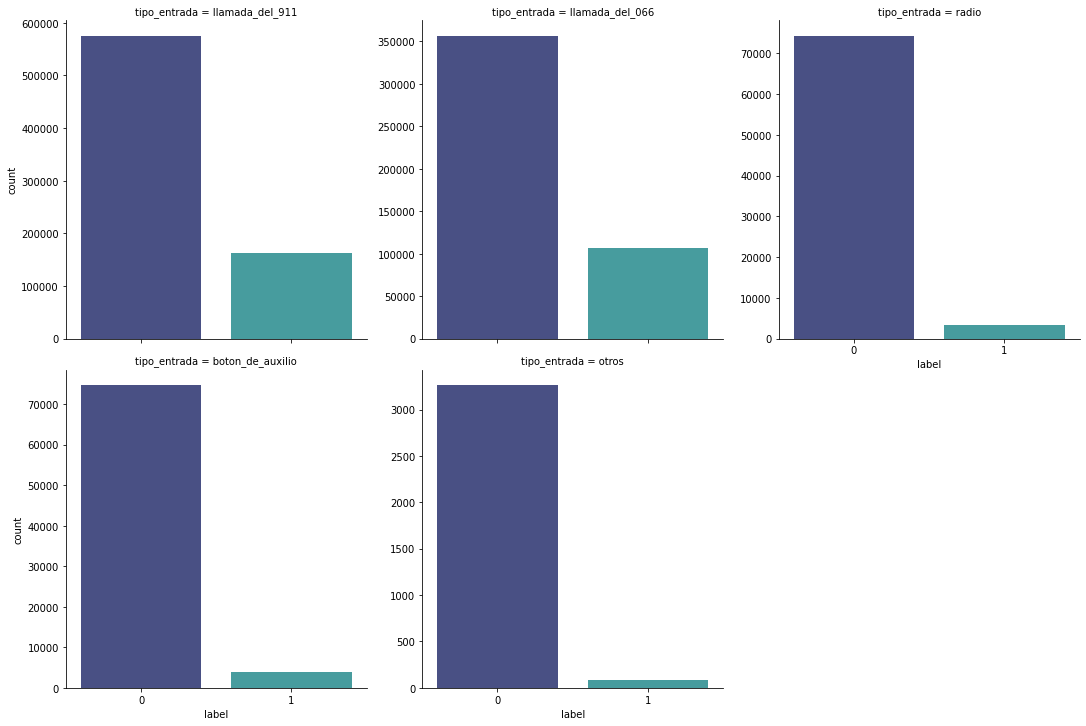

In [131]:
ax = sns.catplot(data = data_copy, x = 'label', kind = 'count', col = 'tipo_entrada', col_wrap= 3, sharey = False, palette = pal,
                 col_order = orden_entradas)

Vemos que las entradas por radio tienen proporciones muy bajas de Falsas Alarmas, mientras que redes y aplicativos tienen las propociones más altas

### Dia de la semana en el que se recibe la llamada

In [133]:
#ax = sns.catplot(data = data_clean, x = 'label', kind = 'count', col = 'dow_creacion', col_wrap= 3, sharey = False)

En general, no hay mucha diferencia en la proporción de llamadas falsas según el dia de la semana

### Mes creación

In [134]:
#ax = sns.catplot(data = data_clean, x = 'label', kind = 'count', col = 'mes_creacion', col_wrap= 3, sharey = False)

Al igual que por día de la semana, no se observan diferencias considerables en la proporción de llamadas falsas según el mes en las que se recibe la llamada

## Data para RF

In [142]:
data_rf = data_clean.loc[:,~data_clean.columns.str.contains('_cierre')]

data_rf = data_rf.drop(columns = ['folio', 'clas_con_f_alarma', 'latitud', 'longitud', 'dttm_creacion', 'fecha_creacion', 'año_creacion'])

data_rf

,delegacion_inicio,incidente_c4,tipo_entrada,dow_creacion,hora_creacion,mes_creacion,geopoint,label
1164271,alvaro obregon,lesionado_atropellado,llamada_del_066,1,23,12,"-99.25598,19.33929",0
1164423,alvaro obregon,accidente_choque_sin_lesionados,llamada_del_066,1,18,12,"-99.2009,19.37831",1
372612,alvaro obregon,accidente_choque_con_lesionados,llamada_del_066,2,21,1,"-99.19104,19.36336",0
372622,alvaro obregon,accidente_choque_sin_lesionados,llamada_del_066,2,21,1,"-99.19145,19.36348",0
372628,alvaro obregon,accidente_choque_sin_lesionados,llamada_del_066,2,6,1,"-99.20009,19.38161",0
...,...,...,...,...,...,...,...,...
1380319,xochimilco,accidente_choque_sin_lesionados,llamada_del_911,5,6,10,"-99.12949,19.28373",0
1382406,xochimilco,accidente_choque_sin_lesionados,llamada_del_911,5,21,10,"-99.10249,19.29447",0
1382445,xochimilco,accidente_choque_con_lesionados,llamada_del_911,5,20,10,"-99.13296,19.21005",1
1382469,xochimilco,accidente_choque_con_lesionados,llamada_del_911,5,7,10,"-99.12949,19.28373",0


In [143]:
outfile = open('data_rf.pickle','wb')
pickle.dump(data_rf,outfile)

outfile.close()